Copyright (c) 2015, 2016
[Sebastian Raschka](http://sebastianraschka.com/)
[Li-Yi Wei](http://www.liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 2 - Training Machine Learning Algorithms for Classification

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib

 
last updated: 2016-08-03 

CPython 3.5.1
IPython 4.1.2

numpy 1.10.4
pandas 0.18.0
matplotlib 1.5.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

# Linear perceptron

A very simple model to illustrate machine learning
* classification
* learning

Inspired by biological brains

### Overview


- [Artificial neurons - a brief glimpse into the early history
of machine learning](#Artificial-neurons-a-brief-glimpse-into-the-early-history-of-machine-learning)
- [Implementing a perceptron learning algorithm in Python](#Implementing-a-perceptron-learning-algorithm-in-Python)
    - [Training a perceptron model on the Iris dataset](#Training-a-perceptron-model-on-the-Iris-dataset)
- [Adaptive linear neurons and the convergence of learning](#Adaptive-linear-neurons-and-the-convergence-of-learning)
    - [Minimizing cost functions with gradient descent](#Minimizing-cost-functions-with-gradient-descent)
    - [Implementing an Adaptive Linear Neuron in Python](#Implementing-an-Adaptive-Linear-Neuron-in-Python)
    - [Large scale machine learning and stochastic gradient descent](#Large-scale-machine-learning-and-stochastic-gradient-descent)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

# Artificial neurons - a brief glimpse into the early history of machine learning

<img src="./images/02_01.png" width=100%> 

Biological neurons were the early inspirations for machine learning.

Current neural networks implement neurons via programs, but people are starting to build electronic circuits to more efficiently emulate neurons.
<a href="http://www.economist.com/news/science-and-technology/21703301-narrowing-gap-between-biological-brains-and-electronic-ones-researchers-have">
<img src="http://cdn.static-economist.com/sites/default/files/imagecache/full-width/images/2016/08/articles/main/20160806_stp003.jpg" width=80% alt="Researchers have built an artificial neuron"></a>


# Perceptron

Proposed by Rosenblatt in 1957 as a very simple model for artifical neurons.


## Representation

A single artificial neuron can be used for binary classification via:
$$
\Phi(z) = 
\begin{cases}
1 \; if z \geq \theta \\
-1 \; otherwise
\end{cases}
$$
, where $\pm 1$ are the class labels, $\Phi$ is the activation function, $\theta$ is some activation threshold, and $z$ is computed from the input $\mathbf{x}$ and neuron weights $\mathbf{w}$
$$
z = \mathbf{w}^T \mathbf{x}
$$

In terms of our general model $f\left(\mathbf{X}, \Theta \right)$, the parameter set are the weights $\Theta = \mathbf{w}$ and the input set $\mathbf{X} = \mathbf{x}$:
$$\Phi(z) = f(\mathbf{x}, \mathbf{w}) = \mathbf{w}^T \mathbf{x}$$


Note that both $\mathbf{w}$ and $\mathbf{x}$ are vectors and the above equations is simply computing their inner products.
Specifically,
$$
\begin{align}
\mathbf{w} = 
\begin{bmatrix}
w_0 \\
\vdots \\
w_m
\end{bmatrix}
,
\mathbf{x} = 
\begin{bmatrix}
x_0 \\
\vdots \\
x_m
\end{bmatrix}
\end{align}
$$

For example $m = 3$:
$$
\begin{align}
\mathbf{w} = 
\begin{bmatrix}
1 \\
2 \\
3
\end{bmatrix}
,
\mathbf{x} = 
\begin{bmatrix}
4 \\
5 \\
6
\end{bmatrix}
\end{align}
$$
$$
\mathbf{w}^T \mathbf{x} = 
\begin{bmatrix}
1 & 2 & 3
\end{bmatrix}
\begin{bmatrix}
4 \\
5 \\
6
\end{bmatrix}
=
1 \times 4 + 2 \times 5 + 3 \times 6
= 32
$$

The convention is to let $x_0 = 1$ and $w_0 = -\theta$ (the bias term), so that we can simplify the model to:
$$
\Phi(z) = 
\begin{cases}
1 \; if z \geq 0 \\
-1 \; otherwise
\end{cases}
$$

## Example

2D case, i.e. $m = 2$

The left visualizes $\Phi(z)$, the right illustrates a binary classification:
<img src = "./images/02_02.png" width=100%> 

## Training

How to train a perceptron so that it can learn from new data?

Let the training data be $\left( \mathbf{X}, \mathbf{T} \right)$, where 
* $\mathbf{X}$: input vectors
* $\mathbf{T}$: labels, $\pm 1$ for each input vector

The training steps are as follows:
* Initialize $\mathbf{w}$ to $0$ or random
* For each training pair $\left(\mathbf{x}^{(i)}, t^{(i)}\right)$
 1. Compute the predicted output $y^{(i)} = \Phi(\mathbf{w}^T \mathbf{x}^{(i)})$
 2. Compute $\delta \mathbf{w} = \eta (t^{(i)} - y^{(i)}) \mathbf{x}^{(i)}$, and update $\mathbf{w} \leftarrow \mathbf{w} + \delta \mathbf{w}$
 
$\eta$ is called the learning rate.

<img src="./images/02_04.png" width=80%> 

### Why this works

If the prediction is correct, i.e. $y^{(i)} = t^{(i)}$, $\rightarrow$ $\delta \mathbf{w} = 0$, so no update.

If the prediction is incorrect
 * $t^{(i)} = 1, y^{(i)} = -1$ $\rightarrow$ $\delta \mathbf{w} = \eta(2)\mathbf(x)^{(i)}$ 
 * $t^{(i)} = -1, y^{(i)} = 1$ $\rightarrow$ $\delta \mathbf{w} = \eta(-2)\mathbf(x)^{(i)}$

$\delta \mathbf{w}$ will move towards the right direction, more positively/negatively correlated with $\mathbf{x}$.


## Linear separability

A single perception is limited to linear classification.

We can handle more general cases via neural networks consisting of multiple perceptrons/neurons.

<img src="./images/02_03.png" width=80%> 

The binary threshold activation function is not differentiable; we will fix this later via other activation functions.
<img src = "./images/02_02.png" width=80%> 

# Implementing a perceptron learning algorithm in Python

In [3]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

**Additional Note**

I received a note by a reader who asked about the net input function:

>On page 27, you describe the code.

> the net_input method simply calculates the vector product wTx
However, there is more than a simple vector product in the code:

> def net_input(self, X):  
    """Calculate net input"""  
    return np.dot(X, self.w_[1:]) + self.w_[0]  
   
> In addition to the dot product, there is an addition. The text does not mention anything about what is this + self.w_[0]
> Can you (or anyone) explain why that's there?

-------

Sorry that I went over that so briefly. The `self.w_[0]` is basically the "threshold" or so-called "bias unit." I simply included the bias unit in the weight vector, which makes the math part easier, but on the other hand, it may make the code more confusing as you mentioned.



Let's say we have a 3x2 dimensional dataset `X` (3 training samples with 2 features). Also, let's just assume we have a weight `2` for feature 1 and a weight `3` for feature 2, and we set the bias unit to `4`. 

```
import numpy as np
>>> bias = 4.
>>> X = np.array([[2., 3.], 
...              [4., 5.], 
...              [6., 7.]])
>>> w = np.array([bias, 2., 3.])
```

In order to match the mathematical notation, we would have to add a vector of 1s to compute the dot-product:

```
>>> ones = np.ones((X.shape[0], 1))
>>> X_with1 = np.hstack((ones, X))
>>> X_with1
>>> np.dot(X_with1, w)
array([ 17.,  27.,  37.])
```

However, I thought that adding a vector of 1s to the training array each time we want to make a prediction would be fairly inefficient. So, instead, we can just "add" the bias unit (`w[0]`) to the do product (it's equivalent, since `1.0 * w_0 = w_0`:

```
>>> np.dot(X, w[1:]) + w[0] 
array([ 17.,  27.,  37.])
```

Maybe it is helpful to walk through the matrix-vector multiplication by hand. E.g.,

```
| 1  2  3 |   | 4 |   | 1*4 + 2*2 + 3*3 |   | 17 |
| 1  4  5 | x | 2 | = | 1*4 + 4*2 + 5*3 | = | 27 |
| 1  6  7 |   | 3 |   | 1*4 + 6*2 + 7*3 |   | 37 |
```

which is the same as

```
| 2  3 |   | 4 |          | 2*2 + 3*3 |          | 13 + bias |   | 17 |
| 4  5 | x | 2 | + bias = | 4*2 + 5*3 | + bias = | 23 + bias | = | 27 |
| 6  7 |   | 3 |          | 6*2 + 7*3 |          | 33 + bias |   | 37 |
```

## Training a perceptron model on the Iris dataset

### Reading-in the Iris data

In [4]:
import pandas as pd

data_src = '../datasets/iris/iris.data'
#data_src = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

df = pd.read_csv(data_src, header=None)

df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


<hr>

### Note:


If the link to the Iris dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/iris/iris.data](./../datasets/iris/iris.data).

Or you could fetch it via https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/iris/iris.data

### Plotting the Iris data

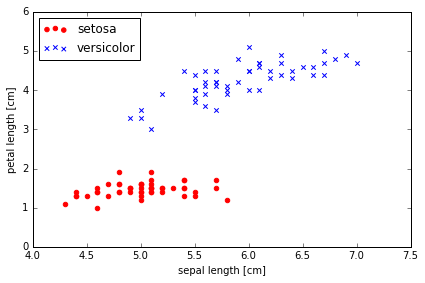

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./images/02_06.png', dpi=300)
plt.show()

### Training the perceptron model

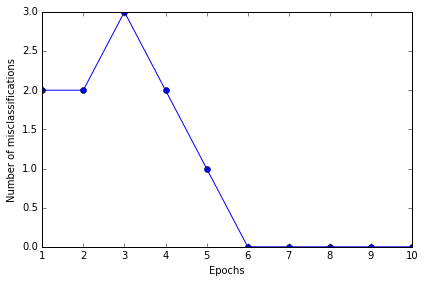

In [6]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')

plt.tight_layout()
# plt.savefig('./perceptron_1.png', dpi=300)
plt.show()

### A function for plotting decision regions

In [7]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

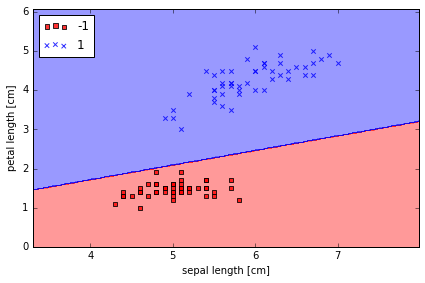

In [8]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./perceptron_2.png', dpi=300)
plt.show()

# Adaptive linear neurons and the convergence of learning

## Minimizing cost functions with gradient descent

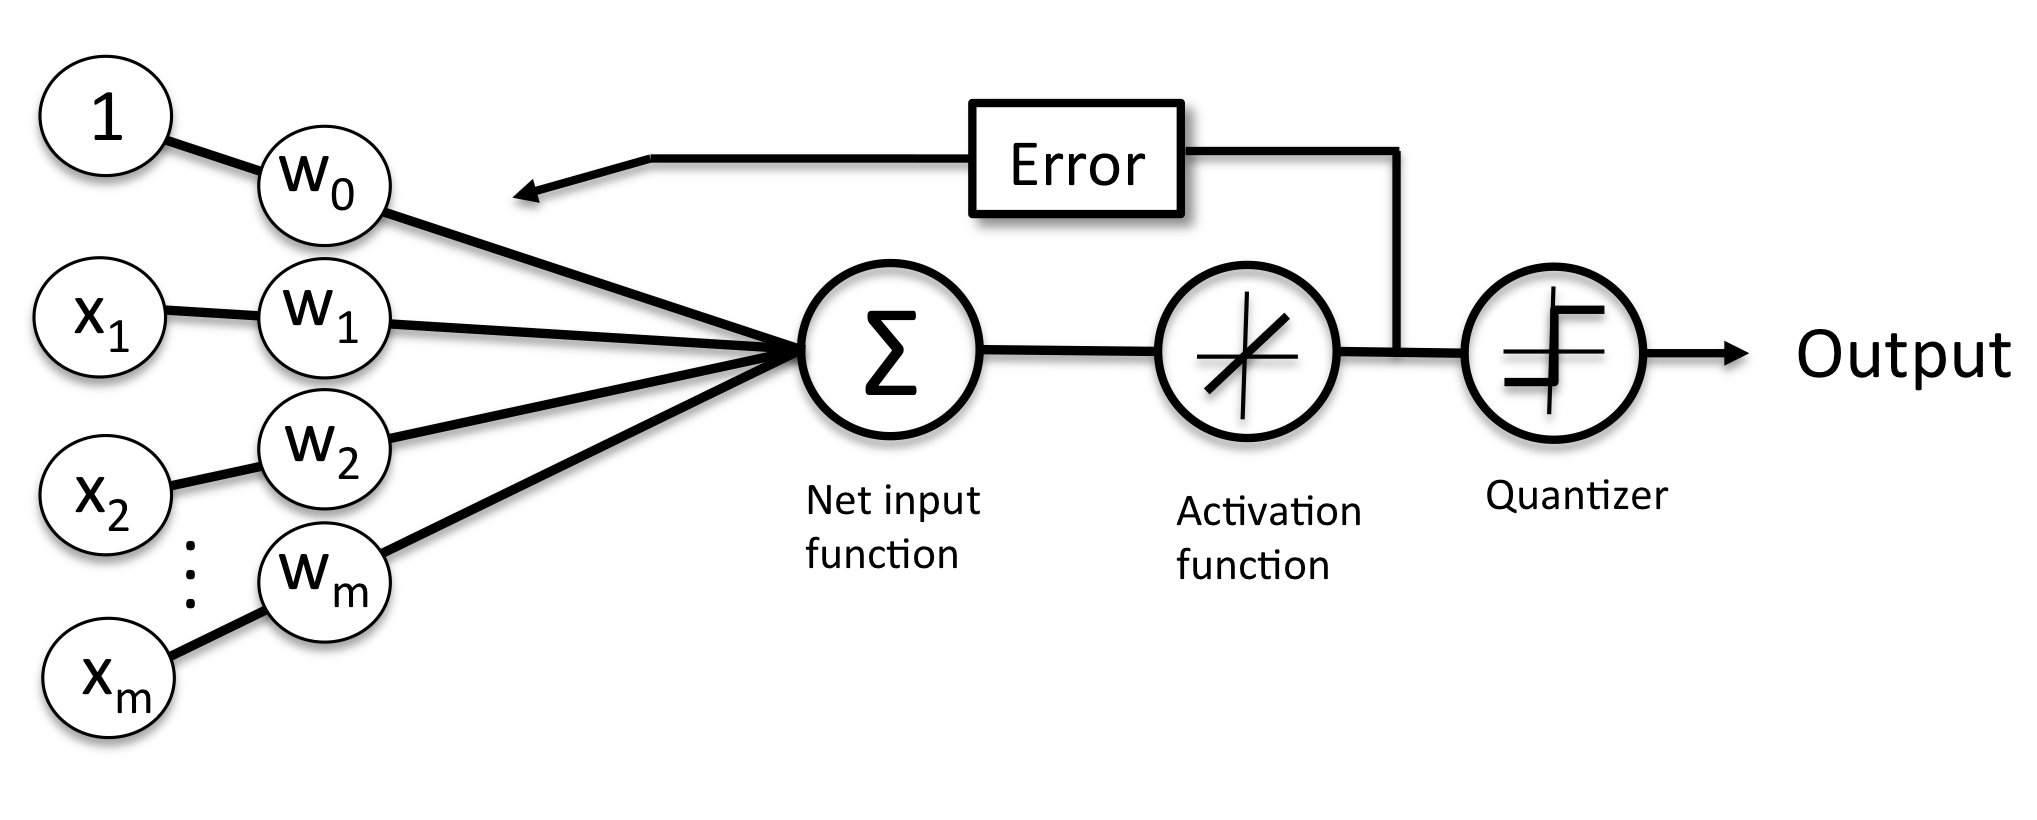

In [9]:
 Image(filename='./images/02_09.png', width=600) 

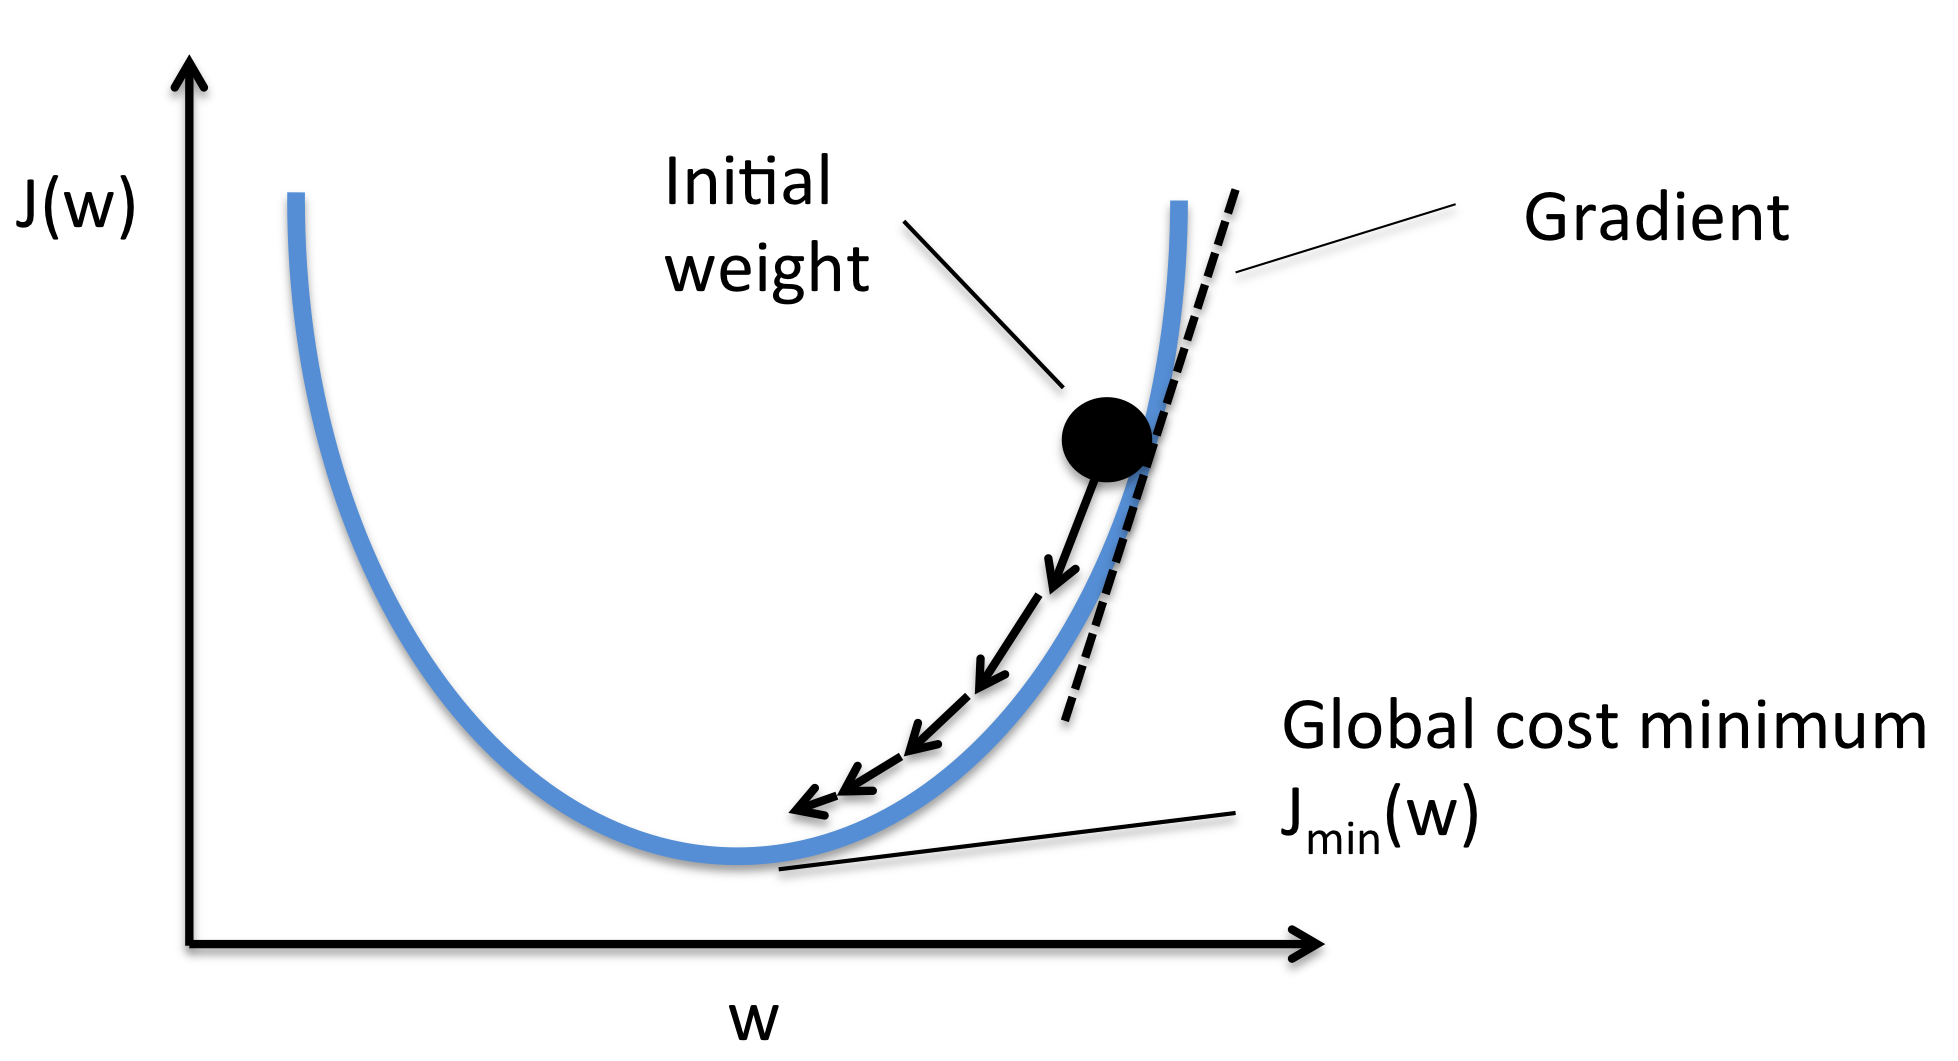

In [10]:
 Image(filename='./images/02_10.png', width=500) 

## Implementing an adaptive linear neuron in Python

In [11]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

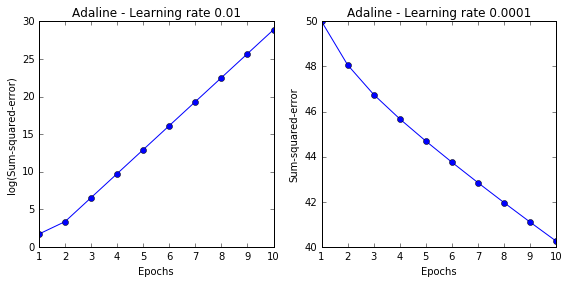

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
# plt.savefig('./adaline_1.png', dpi=300)
plt.show()

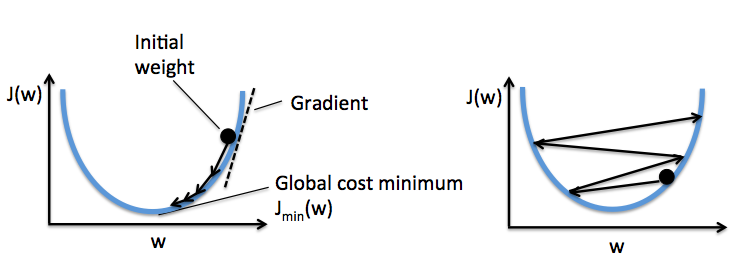

In [13]:
Image(filename='./images/02_12.png', width=700) 

In [14]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

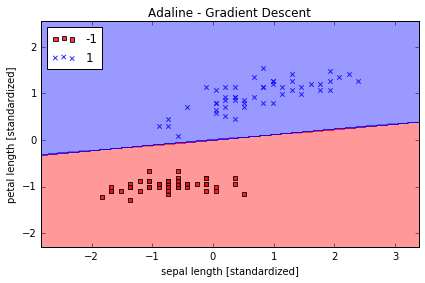

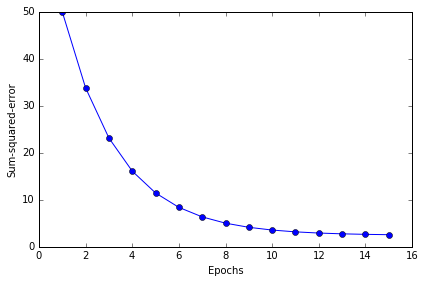

In [15]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./adaline_2.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()

## Large scale machine learning and stochastic gradient descent

In [16]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

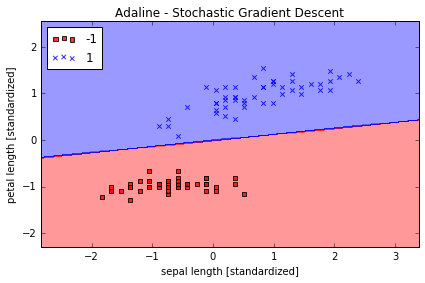

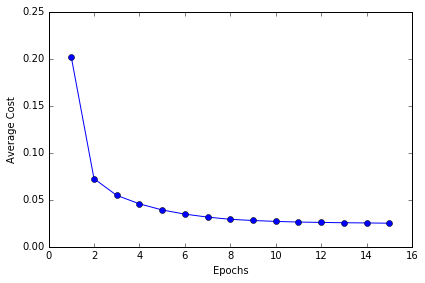

In [17]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./adaline_4.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('./adaline_5.png', dpi=300)
plt.show()

In [18]:
ada.partial_fit(X_std[0, :], y[0])

# Summary